# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

## Part I - WeatherPy

In this example, you'll be creating a Python script to visualize the weather of 500+ cities across the world of varying distance from the equator. To accomplish this, you'll be utilizing a [simple Python library](https://pypi.python.org/pypi/citipy), the [OpenWeatherMap API](https://openweathermap.org/api), and a little common sense to create a representative model of weather across world cities.

Your first requirement is to create a series of scatter plots to showcase the following relationships:

* Temperature (F) vs. Latitude
* Humidity (%) vs. Latitude
* Cloudiness (%) vs. Latitude
* Wind Speed (mph) vs. Latitude

After each plot add a sentence or too explaining what the code is and analyzing.

Your second requirement is to run linear regression on each relationship, only this time separating them into Northern Hemisphere (greater than or equal to 0 degrees latitude) and Southern Hemisphere (less than 0 degrees latitude):

* Northern Hemisphere - Temperature (F) vs. Latitude
* Southern Hemisphere - Temperature (F) vs. Latitude
* Northern Hemisphere - Humidity (%) vs. Latitude
* Southern Hemisphere - Humidity (%) vs. Latitude
* Northern Hemisphere - Cloudiness (%) vs. Latitude
* Southern Hemisphere - Cloudiness (%) vs. Latitude
* Northern Hemisphere - Wind Speed (mph) vs. Latitude
* Southern Hemisphere - Wind Speed (mph) vs. Latitude

After each pair of plots explain what the linear regression is modeling such as any relationships you notice and any other analysis you may have.

**Optional** You will be creating multiple linear regression plots. To optimize your code, write a function that creates the linear regression plots.

Your final notebook must:

* Randomly select **at least** 500 unique (non-repeat) cities based on latitude and longitude.
* Perform a weather check on each of the cities using a series of successive API calls.
* Include a print log of each city as it's being processed with the city number and city name.
* Save a CSV of all retrieved data and a PNG image for each scatter plot.

## * For Part I, you must include a written description of three observable trends based on the data.
* The further away from the equator, the less sunlight that cities received. For that reason, the highest temperature is near the equator and the colder temperatures are in the northern and southern hemispheres.
* There are less cities around the poles in the highest and lowest latitude because it's colder..
* Humidity, cloudiness and wind speed have no or very weak correlation towards latitude. Humidity on cities are mainly higher than 60%, wind speed is mainly less than 10 mph and cloudiness is very variable regardless of latitude. 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import scipy.stats as st
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# URL
url = "http://api.openweathermap.org/data/2.5/weather?"

# Base URL
base_url = f"{url}appid={weather_api_key}"

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

632

In [3]:
# Create a dataframe to view the cities
cities_list={"City Name":cities}
cities_df= pd.DataFrame(cities_list)
cities_df

City Name
0     east london
1    kruisfontein
2       jamestown
3     tuktoyaktuk
4          palora
..            ...
627   salinopolis
628           leh
629       vendome
630      dengzhou
631          ayni

[632 rows x 1 columns]

# Parameters:
## message Internal parameter
### cod Internal parameter
* city_id City ID
* calctime Internal parameter
#### list
* dt Time of data calculation, unix, UTC
* city_name City name
* lat Geographical coordinates of the location (latitude)
* lon Geographical coordinates of the location (longitude)
* dt Time of data calculation, unix, UTC
* dt_isoDate and time in UTC format
* timezone Shift in seconds from UTC
#### main
* main.temp Temperature, Kelvins
* main.feels_like Temperature, Kelvins. This temperature parameter accounts for the human perception of weather
* main.pressure Atmospheric pressure (on the sea level, if there is no sea_level or grnd_level data), hPa
* main.humidity Humidity, %
* main.temp_min Minimum temperature within a large city or a megalopolis (optional parameter), Kelvin
* main.temp_max Maximum temperature within a large city or a megalopolis (optional parameter), Kelvins
* main.sea_level Atmospheric pressure on the sea level, hPa
* main.grnd_level Atmospheric pressure on the ground level, hPa
#### wind
* wind.speed Wind speed. Unit: meter/sec.
* wind.deg Wind direction, degrees (meteorological)
#### clouds
* clouds.all Cloudiness, %
#### rain
* rain.1h Rain volume for the last 1 hour
* rain.3h Rain volume for the last 3 hours
#### snow
* snow.1h Snow volume for the last 1 hour
* snow.3h Snow volume for the last 3 hours
#### weather (more info Weather condition codes)
* weather.id Weather condition id
* weather.main Group of weather parameters (Rain, Snow, Extreme etc.)
* weather.description Weather condition within the group
* weather.icon Weather icon id
#### weather unit
* For temperature in Fahrenheit use units=imperial
* For temperature in Celsius use units=metric
* Temperature in Kelvin is used by default, no need to use units parameter in API call

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Create a list for the weather data
cities_data = []
units="imperial"

# Define variables for count until 50 for each set
count = 0
count_restart = 0
count_increase = 1

# Print the Beginning 
print("Beginning Data Retrieval")
print("------------------------------------------------------------------------------")

# Loop through cities and establish the limit count to 50 with a restart on count and print the result for each increase
for city in cities:
    count = count + 1
    if (count % 50 ==0 and count >= 50):
        count_restart = 0
        count_increase = count_increase + 1
    count_restart = count_restart + 1
    print(f"Processing Record {count_restart} of Set {count_increase} | {city}")
# Query URL
    query_url = f"{base_url}&q={city}&units={units}"
# Use try except inside the loop for error handling    
    try:
        response_cities = requests.get(query_url).json()
# Define the parameters of the response which should include Temperature (F), Humidity (%), Cloudiness (%), Wind Speed (mph) and Latitude
# main.temp_min Minimum temperature within a large city or a megalopolis (optional parameter), Kelvin
# main.temp_max Maximum temperature within a large city or a megalopolis (optional parameter), Kelvins
# main.humidity Humidity, %
# clouds.all Cloudiness, %
# wind.speed Wind speed. Unit: meter/sec.
        country = response_cities["sys"]["country"]
        city_name = response_cities["name"]    
        lat = response_cities["coord"]["lat"]
        lon = response_cities["coord"]["lon"]
        min_temp = response_cities["main"]["temp_min"]
        max_temp = response_cities["main"]["temp_max"]
        humidity = response_cities["main"]["humidity"]
        cloudiness = response_cities["clouds"]["all"]
        wind_speed = response_cities["wind"]["speed"]
        country = response_cities["sys"]["country"]
# Append the data to the list cities data 
        cities_data.append({
            "Country": country,
            "Cities": city_name,
            "Latitude": lat,
            "Longitude": lon,
            "Minimum temperature": min_temp,
            "Maximum temperature": max_temp,
            "Humidity": humidity,
            "Cloudiness": cloudiness,
            "Wind Speed": wind_speed})
    except:
            print(f"City not found. Skipping... {city}")

print("------------------------------------------------------------------------------")
print("Data Retrieval Complete")
print("------------------------------------------------------------------------------")

Beginning Data Retrieval
------------------------------------------------------------------------------
Processing Record 1 of Set 1 | east london
Processing Record 2 of Set 1 | kruisfontein
Processing Record 3 of Set 1 | jamestown
Processing Record 4 of Set 1 | tuktoyaktuk
Processing Record 5 of Set 1 | palora
Processing Record 6 of Set 1 | komsomolskiy
Processing Record 7 of Set 1 | baran
Processing Record 8 of Set 1 | lhokseumawe
Processing Record 9 of Set 1 | punta arenas
Processing Record 10 of Set 1 | cururupu
Processing Record 11 of Set 1 | grand river south east
City not found. Skipping... grand river south east
Processing Record 12 of Set 1 | mount isa
Processing Record 13 of Set 1 | zhigansk
Processing Record 14 of Set 1 | port alfred
Processing Record 15 of Set 1 | tasiilaq
Processing Record 16 of Set 1 | ionesti
Processing Record 17 of Set 1 | alice springs
Processing Record 18 of Set 1 | mataura
Processing Record 19 of Set 1 | provideniya
Processing Record 20 of Set 1 | ko

Processing Record 29 of Set 4 | nguiu
City not found. Skipping... nguiu
Processing Record 30 of Set 4 | ancud
Processing Record 31 of Set 4 | muroto
Processing Record 32 of Set 4 | namatanai
Processing Record 33 of Set 4 | beyneu
Processing Record 34 of Set 4 | talnakh
Processing Record 35 of Set 4 | kungurtug
Processing Record 36 of Set 4 | barra do garcas
Processing Record 37 of Set 4 | popondetta
Processing Record 38 of Set 4 | pasighat
Processing Record 39 of Set 4 | marsabit
Processing Record 40 of Set 4 | qaanaaq
Processing Record 41 of Set 4 | thompson
Processing Record 42 of Set 4 | zhangye
Processing Record 43 of Set 4 | pevek
Processing Record 44 of Set 4 | hondo
Processing Record 45 of Set 4 | haibowan
City not found. Skipping... haibowan
Processing Record 46 of Set 4 | khatanga
Processing Record 47 of Set 4 | aasiaat
Processing Record 48 of Set 4 | ocampo
Processing Record 49 of Set 4 | inirida
Processing Record 50 of Set 4 | hermiston
Processing Record 1 of Set 5 | rawson


Processing Record 18 of Set 8 | gijon
Processing Record 19 of Set 8 | sibay
Processing Record 20 of Set 8 | halmstad
Processing Record 21 of Set 8 | labuhan
Processing Record 22 of Set 8 | kununurra
Processing Record 23 of Set 8 | likasi
Processing Record 24 of Set 8 | hami
Processing Record 25 of Set 8 | sterling
Processing Record 26 of Set 8 | cayenne
Processing Record 27 of Set 8 | prince rupert
Processing Record 28 of Set 8 | kawalu
Processing Record 29 of Set 8 | skibbereen
Processing Record 30 of Set 8 | jalu
Processing Record 31 of Set 8 | narsaq
Processing Record 32 of Set 8 | hovd
Processing Record 33 of Set 8 | wenling
Processing Record 34 of Set 8 | gogrial
Processing Record 35 of Set 8 | muros
Processing Record 36 of Set 8 | varhaug
Processing Record 37 of Set 8 | sao miguel
Processing Record 38 of Set 8 | kegayli
City not found. Skipping... kegayli
Processing Record 39 of Set 8 | redlands
Processing Record 40 of Set 8 | mersing
Processing Record 41 of Set 8 | troitskoye
Pr

Processing Record 6 of Set 12 | san jose
Processing Record 7 of Set 12 | kavaratti
Processing Record 8 of Set 12 | tuggurt
City not found. Skipping... tuggurt
Processing Record 9 of Set 12 | lolua
City not found. Skipping... lolua
Processing Record 10 of Set 12 | luorong
Processing Record 11 of Set 12 | tabou
Processing Record 12 of Set 12 | scottsbluff
Processing Record 13 of Set 12 | bonito
Processing Record 14 of Set 12 | alta floresta
Processing Record 15 of Set 12 | alamogordo
Processing Record 16 of Set 12 | portland
Processing Record 17 of Set 12 | hameenlinna
Processing Record 18 of Set 12 | acajutla
Processing Record 19 of Set 12 | karamay
City not found. Skipping... karamay
Processing Record 20 of Set 12 | yarmouth
Processing Record 21 of Set 12 | shirokiy
Processing Record 22 of Set 12 | ramsar
Processing Record 23 of Set 12 | zhezkazgan
Processing Record 24 of Set 12 | karla
Processing Record 25 of Set 12 | tulsipur
Processing Record 26 of Set 12 | vila
Processing Record 27

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
cities_data_df = pd.DataFrame(cities_data)
cities_data_df.head()

Country        Cities  Latitude  Longitude  Minimum temperature  \
0      ZA   East London    -33.02      27.91                76.23   
1      ZA  Kruisfontein    -34.00      24.73                60.22   
2      US     Jamestown     42.10     -79.24                57.20   
3      CA   Tuktoyaktuk     69.45    -133.04                 6.80   
4      EC        Palora     -1.70     -77.93                71.60   

   Maximum temperature  Humidity  Cloudiness  Wind Speed  
0                76.23        38           0        5.26  
1                60.22        69           1       10.02  
2                57.20        50          75       16.11  
3                 6.80        92          40       12.75  
4                71.60        94          90        2.24

In [6]:
cities_data_df.count()

Country                579
Cities                 579
Latitude               579
Longitude              579
Minimum temperature    579
Maximum temperature    579
Humidity               579
Cloudiness             579
Wind Speed             579
dtype: int64

In [7]:
# Saving the dataframe as a csv file
cities_data_df.to_csv("Cities weather worldwide.csv")

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

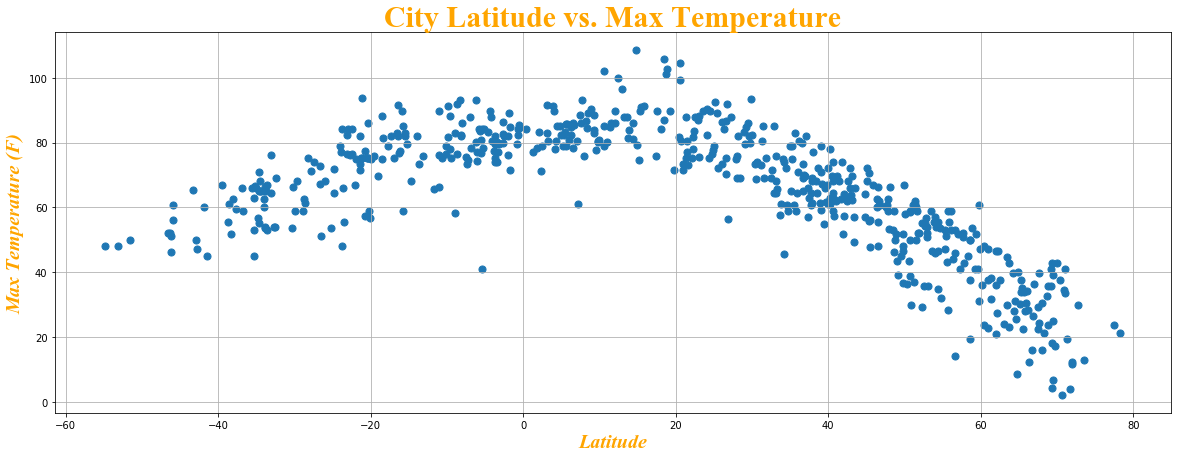

The correlation between both factors is -0.54


In [8]:
# Scatter plot the data with Matplotlib 
cities_latitude = cities_data_df["Latitude"]
cities_maximum_temperature = cities_data_df["Maximum temperature"]
correlation = st.pearsonr(cities_latitude, cities_maximum_temperature)
cities_data_df.plot(kind="scatter", x="Latitude", y="Maximum temperature",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Max Temperature (F)",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.title("City Latitude vs. Max Temperature",fontsize=30,fontweight="semibold", family="Times New Roman",color="orange")
plt.savefig("latitudevstemperature.png") 
plt.show()
print(f"The correlation between both factors is {round(correlation[0],2)}")

### * Cities from the sample that are closer to the equator are warmer, the temperature rises in cities while approaching to the equator.
### * Cities from the sample in the north and south are colder, the temperature decreases in cities while approaching to the north and south.
### * There is none correlation between both factors.

#### Latitude vs. Humidity Plot

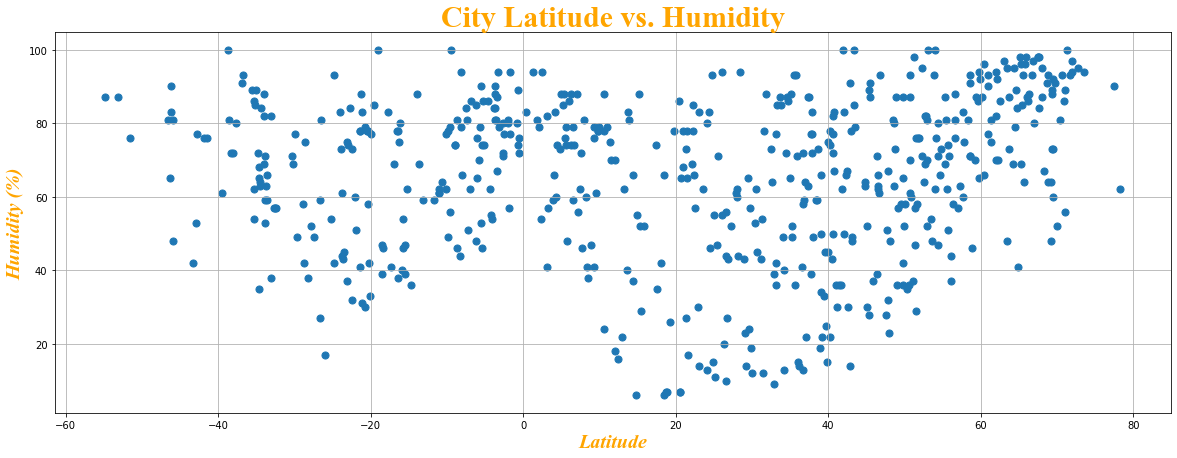

The correlation between both factors is 0.07


In [9]:
# Scatter plot the data with Matplotlib 
cities_humidity = cities_data_df["Humidity"]
correlation = st.pearsonr(cities_latitude, cities_humidity)
cities_data_df.plot(kind="scatter", x="Latitude", y="Humidity",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Humidity (%)",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.title("City Latitude vs. Humidity",fontsize=30,fontweight="semibold", family="Times New Roman",color="orange")
plt.savefig("latitudevshumidity.png") 
plt.show()
print(f"The correlation between both factors is {round(correlation[0],2)}")

### * Cities from the sample have high humidity percentage regardless of its latitude.
### * There is very weak correlation between both factors.

#### Latitude vs. Cloudiness Plot

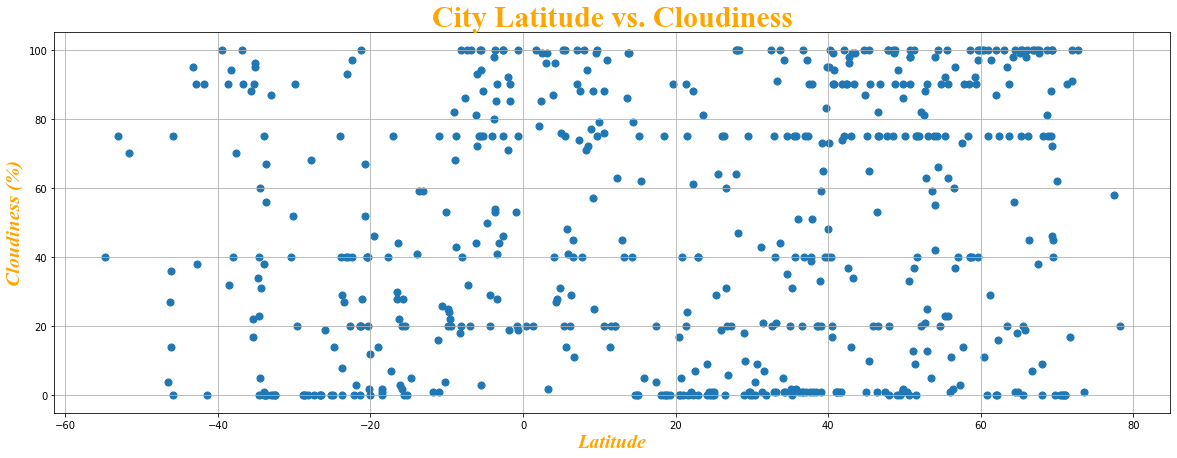

The correlation between both factors is 0.15


In [10]:
# Scatter plot the data with Matplotlib 
cities_cloudiness = cities_data_df["Cloudiness"]
correlation = st.pearsonr(cities_latitude, cities_cloudiness)
cities_data_df.plot(kind="scatter", x="Latitude", y="Cloudiness",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Cloudiness (%)",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.title("City Latitude vs. Cloudiness",fontsize=30,fontweight="semibold", family="Times New Roman",color="orange")
plt.savefig("latitudevscloudiness.png") 
plt.show()
print(f"The correlation between both factors is {round(correlation[0],2)}")

### * Cities from the sample are mainly cloudy regardless of its latitude.
### * There is very weak correlation between both factors.

#### Latitude vs. Wind Speed Plot

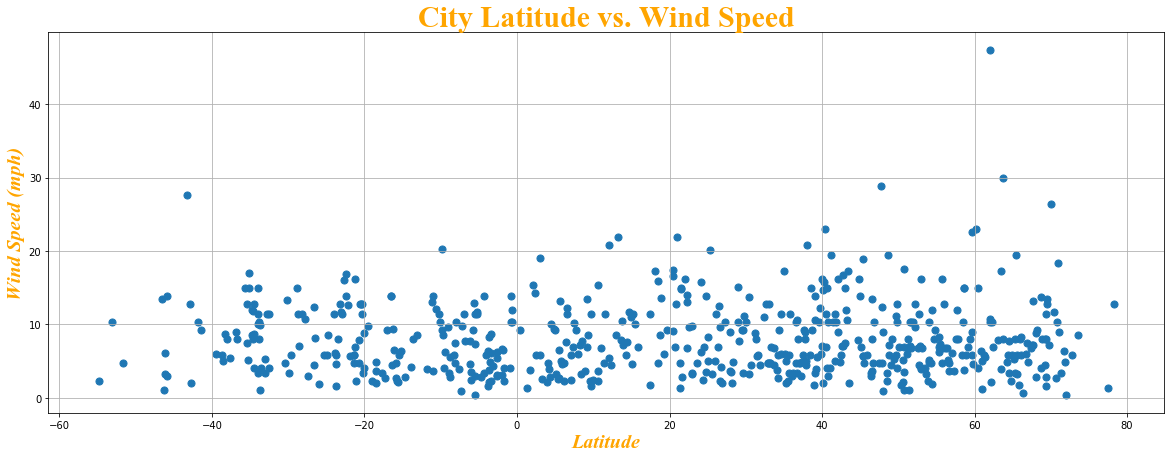

The correlation between both factors is 0.03


In [11]:
# Scatter plot the data with Matplotlib 
cities_windspeed = cities_data_df["Wind Speed"]
correlation = st.pearsonr(cities_latitude, cities_windspeed)
cities_data_df.plot(kind="scatter", x="Latitude", y="Wind Speed",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Wind Speed (mph)",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.title("City Latitude vs. Wind Speed",fontsize=30,fontweight="semibold", family="Times New Roman",color="orange")
plt.savefig("latitudevswindspeed.png") 
plt.show()
print(f"The correlation between both factors is {round(correlation[0],2)}")

In [12]:
round(cities_windspeed.mean(),0)

8.0

### * Cities from the sample have an average wind speed around 8 mph regardless of its latitude.
### * There is none correlation between both factors.

## Linear Regression

In [13]:
# OPTIONAL: Create a function to create Linear Regression plots
# Create Northern and Southern Hemisphere DataFrames
# Plot the linear regression model on top of the previous scatter plot.

In [14]:
cities_data_North_df=cities_data_df.loc[cities_data_df["Latitude"] > 0]
cities_data_North_df.head()

Country           Cities  Latitude  Longitude  Minimum temperature  \
2      US        Jamestown     42.10     -79.24                57.20   
3      CA      Tuktoyaktuk     69.45    -133.04                 6.80   
5      UZ  Yangi Marg`ilon     40.43      71.72                69.80   
6      IN            Bārān     25.10      76.52                92.66   
7      ID      Lhokseumawe      5.18      97.15                78.84   

   Maximum temperature  Humidity  Cloudiness  Wind Speed  
2                57.20        50          75       16.11  
3                 6.80        92          40       12.75  
5                69.80        43          40       23.04  
6                92.66        11           0        4.94  
7                78.84        85         100        3.18

In [15]:
cities_data_South_df=cities_data_df.loc[cities_data_df["Latitude"] < 0]
cities_data_South_df.head()

Country        Cities  Latitude  Longitude  Minimum temperature  \
0      ZA   East London    -33.02      27.91                76.23   
1      ZA  Kruisfontein    -34.00      24.73                60.22   
4      EC        Palora     -1.70     -77.93                71.60   
8      CL  Punta Arenas    -53.15     -70.92                48.00   
9      BR      Cururupu     -1.83     -44.87                89.01   

   Maximum temperature  Humidity  Cloudiness  Wind Speed  
0                76.23        38           0        5.26  
1                60.22        69           1       10.02  
4                71.60        94          90        2.24  
8                48.20        87          75       10.29  
9                89.01        57          19        6.49

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: -0.88
The equation of the regression line is: y = -0.97x + 99.64


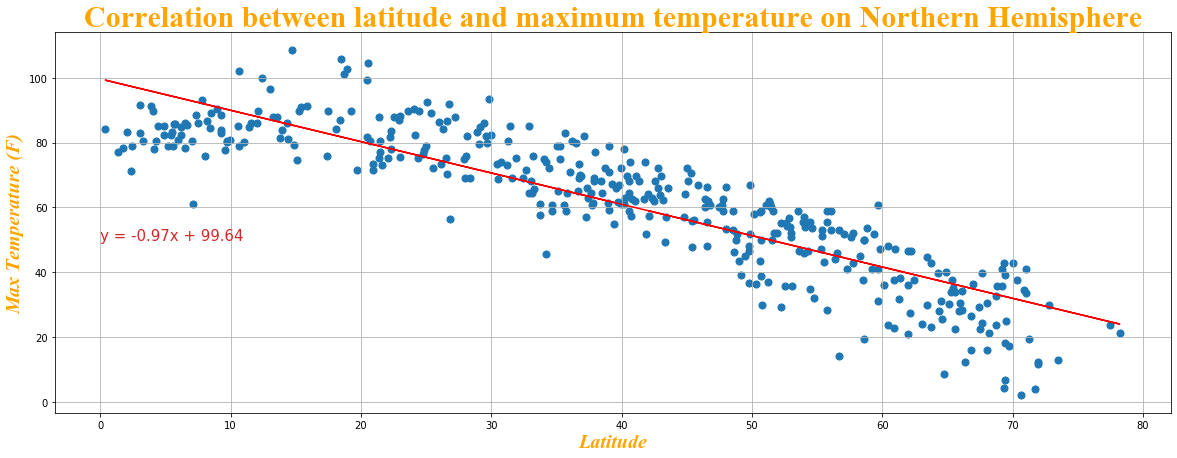

In [16]:
north_cities_latitude = cities_data_North_df["Latitude"]
north_cities_maximum_temperature = cities_data_North_df["Maximum temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(north_cities_latitude, north_cities_maximum_temperature)
regress_values = north_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_North_df.plot(kind="scatter", x="Latitude", y="Maximum temperature",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(north_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and maximum temperature on Northern Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Max Temperature (F)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("northlatitudevstemperature.png") 
plt.show()

In [17]:
north_cities_maximum_temperature.min()

1.89

### * Cities from the sample in the north are colder, the temperature decreases in cities while approaching to the north.
### * The city in the north with the colder temperature has 2 Farenheith degrees.
### * There is none correlation between both factors.

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.73
The equation of the regression line is: y = 0.66x + 85.13


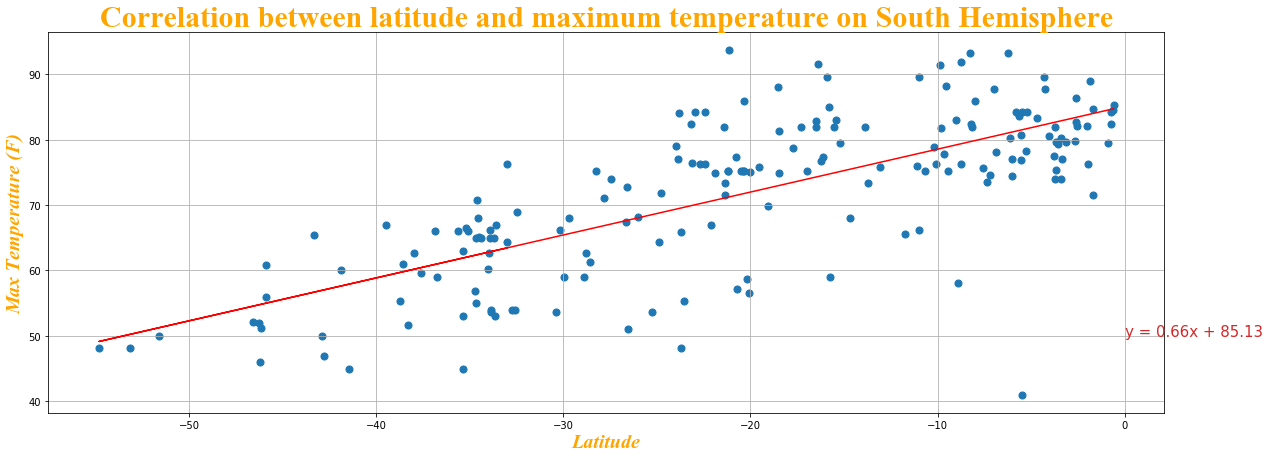

In [18]:
south_cities_latitude = cities_data_South_df["Latitude"]
south_cities_maximum_temperature = cities_data_South_df["Maximum temperature"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(south_cities_latitude, south_cities_maximum_temperature)
regress_values = south_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_South_df.plot(kind="scatter", x="Latitude", y="Maximum temperature",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(south_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and maximum temperature on South Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Max Temperature (F)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("southlatitudevstemperature.png") 
plt.show()

In [19]:
south_cities_maximum_temperature.min()

40.89

### * Cities from the sample in the south are colder, the temperature decreases in cities while approaching to the and south.
### * The city in the south with the colder temperature has 41 Farenheith degrees.
### * There is a strong correlation between both factors.

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.29
The equation of the regression line is: y = 0.35x + 50.34


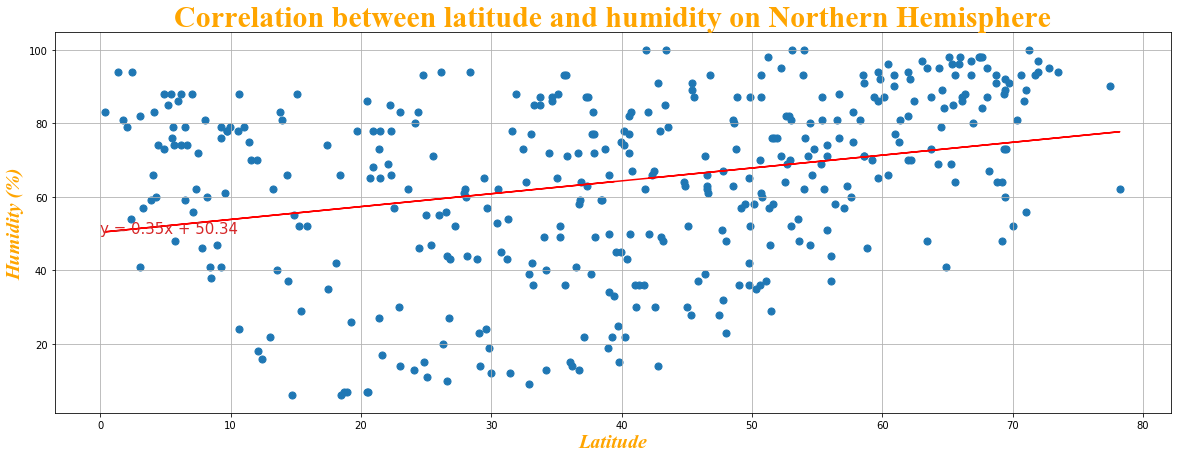

In [20]:
north_cities_humidity = cities_data_North_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(north_cities_latitude, north_cities_humidity)
regress_values = north_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_North_df.plot(kind="scatter", x="Latitude", y="Humidity",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(north_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and humidity on Northern Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Humidity (%)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("northlatitudevshumidity.png") 
plt.show()

### * Cities from the sample have high humidity percentage in the north.
### * There is a very weak correlation between both factors.

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.06
The equation of the regression line is: y = 0.08x + 69.29


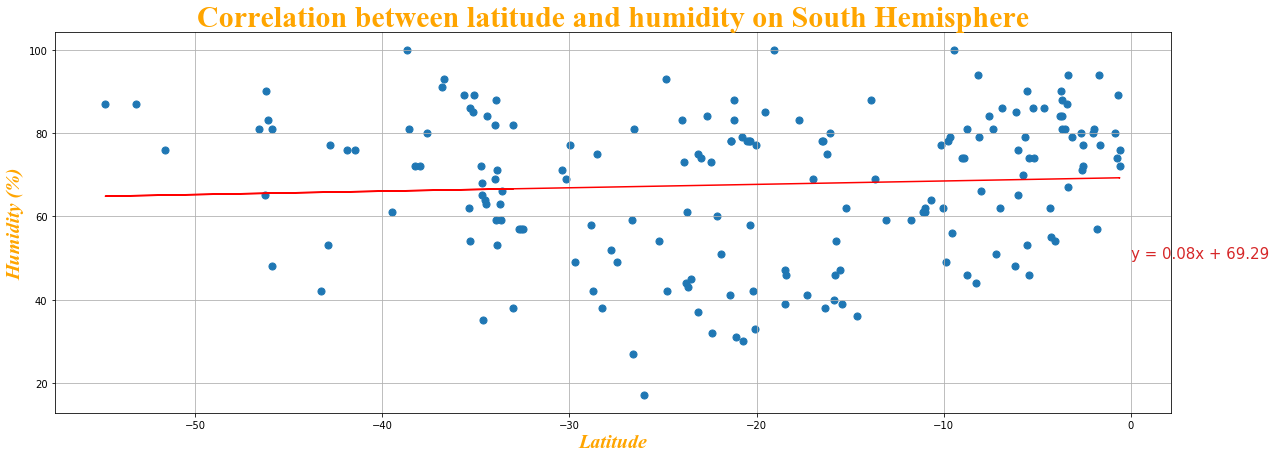

In [21]:
south_cities_humidity = cities_data_South_df["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(south_cities_latitude, south_cities_humidity)
regress_values = south_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_South_df.plot(kind="scatter", x="Latitude", y="Humidity",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(south_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and humidity on South Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Humidity (%)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("southlatitudevshumidity.png") 
plt.show()

### * Cities from the sample have high humidity percentage in the south.
### * There is a very weak correlation between both factors.

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.11
The equation of the regression line is: y = 0.22x + 41.98


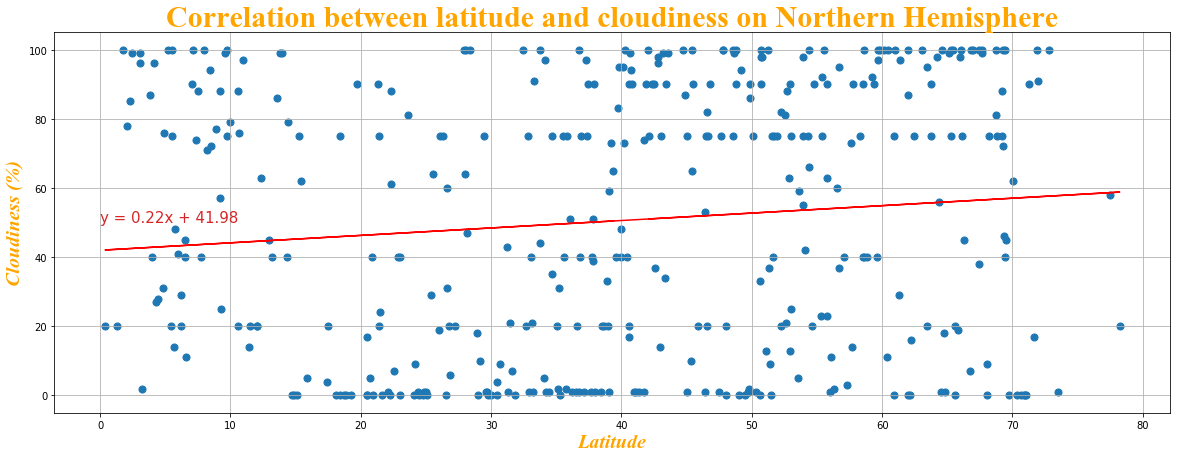

In [22]:
north_cities_cloudiness = cities_data_North_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(north_cities_latitude, north_cities_cloudiness)
regress_values = north_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_North_df.plot(kind="scatter", x="Latitude", y="Cloudiness",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(north_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and cloudiness on Northern Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Cloudiness (%)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("northlatitudevscloudiness.png") 
plt.show()

### * Cities from the sample are mainly cloudy in the north.
### * There is a very weak correlation between both factors.

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.17
The equation of the regression line is: y = 0.44x + 51.47


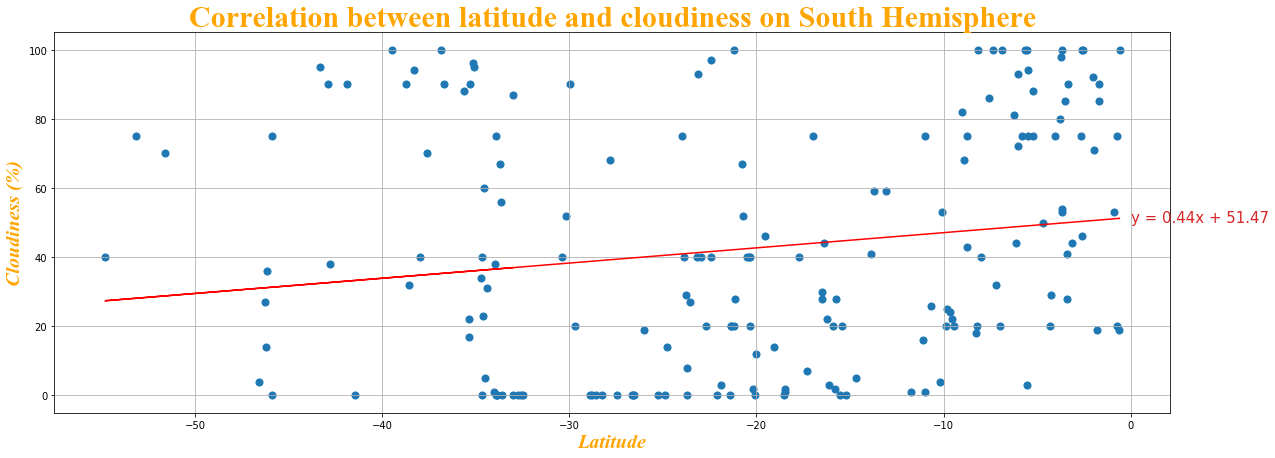

In [23]:
south_cities_cloudiness = cities_data_South_df["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(south_cities_latitude, south_cities_cloudiness)
regress_values = south_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_South_df.plot(kind="scatter", x="Latitude", y="Cloudiness",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(south_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and cloudiness on South Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Cloudiness (%)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("southlatitudevscloudiness.png") 
plt.show()

### * Cities from the sample are mainly cloudy in the south.
### * There is a very weak correlation between both factors.

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.02
The equation of the regression line is: y = 0.01x + 7.89


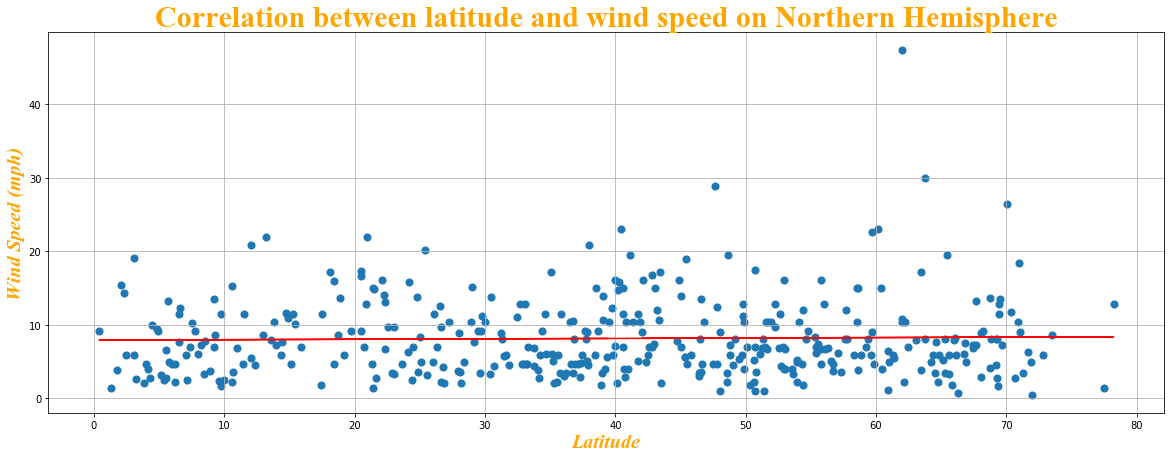

In [24]:
north_cities_windspeed = cities_data_North_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(north_cities_latitude, north_cities_windspeed)
regress_values = north_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_North_df.plot(kind="scatter", x="Latitude", y="Wind Speed",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(north_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and wind speed on Northern Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Wind Speed (mph)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("northlatitudevswindspeed.png") 
plt.show()

In [25]:
round(north_cities_windspeed.mean(),0)

8.0

### * Cities from the sample have an average wind speed around 4 mph in the north.
### * There is none correlation between both factors.

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: -0.17
The equation of the regression line is: y = -0.05x + 6.52


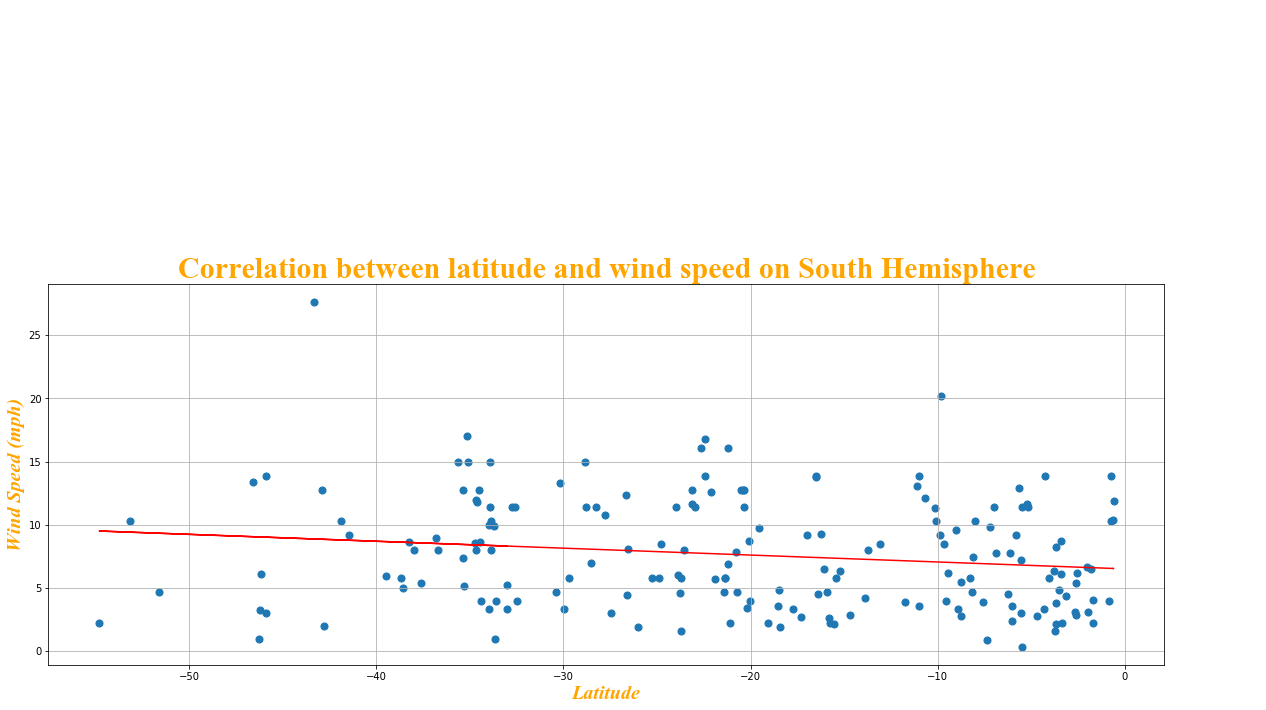

In [26]:
south_cities_windspeed = cities_data_South_df["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(south_cities_latitude, south_cities_windspeed)
regress_values = south_cities_latitude * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
cities_data_South_df.plot(kind="scatter", x="Latitude", y="Wind Speed",marker="o",color="tab:blue",s=50,figsize=(20,7),grid=True)
plt.plot(south_cities_latitude,regress_values,"r-")
plt.annotate(line_eq,(0,50),fontsize=15,color="tab:red")
plt.title(f"Correlation between latitude and wind speed on South Hemisphere",fontsize=30,fontweight="semibold", color="orange", family="Times New Roman")
plt.xlabel("Latitude",style="italic",family="Times New Roman",fontsize=20,color="orange")
plt.ylabel("Wind Speed (mph)",style="italic",family="Times New Roman",fontsize=20,color="orange")
print(f"The r-squared is: {round(rvalue,2)}")
print(f"The equation of the regression line is: {line_eq}")
plt.savefig("southlatitudevswindspeed.png") 
plt.show()

In [27]:
round(south_cities_windspeed.mean(),0)

8.0

### * Cities from the sample have an average wind speed around 4 mph in the south.
### * There is none correlation between both factors.